# Heurística para el TSP: Inserción más cercana

Tenemos un vector de 8 ciudades $V = \{1,2,3,4,5,6,7,8\}$ junto con sus coordenadas con una matriz de distancias.

In [1]:
V = collect(1:8)

8-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8

In [2]:
using Distances
coordinates = 
[86 37
17 94
3 65
48 43
78 70
17 55
62 91
78 91]

8×2 Matrix{Int64}:
 86  37
 17  94
  3  65
 48  43
 78  70
 17  55
 62  91
 78  91

En base a las coordenadas, podemos obtener la matriz de distancias $D = d_{i,j}; i, j \in V$ correspondiente

In [3]:
distances = pairwise(Euclidean(), coordinates, dims=1)
D = trunc.(Int, distances)

8×8 Matrix{Int64}:
  0  89  87  38  33  71  59  54
 89   0  32  59  65  39  45  61
 87  32   0  50  75  17  64  79
 38  59  50   0  40  33  50  56
 33  65  75  40   0  62  26  21
 71  39  17  33  62   0  57  70
 59  45  64  50  26  57   0  16
 54  61  79  56  21  70  16   0

Y tenemos un conjunto $T$ que representa nuestra ruta

In [4]:
T = Int64[]

Int64[]

Todo esto se hace con la idea de minimizar las distancias entre las ciudades, conectándolas una con otra. 

Para empezar, vamos a elegir la distancia más pequeña disponible en la matriz. Ahora, como soy perezoso, usaré la función `findmin` definida en Julia, pero ésta retornará los elementos cero de la diagonal principal. Así que lo primero que haré es reemplazar todos aquellos con distancias no deseadas. Una aproximación ingenua sería simplemente hacer un `replace` pero esto se ensuciará con otros 0s en la matriz, así que vamos a ceñirnos a la diagonal. También podría usar la stdlib de LinearAlgebra.

In [5]:
for i ∈ 1:8
    D[i, i] = 999999
end
D

8×8 Matrix{Int64}:
 999999      89      87      38      33      71      59      54
     89  999999      32      59      65      39      45      61
     87      32  999999      50      75      17      64      79
     38      59      50  999999      40      33      50      56
     33      65      75      40  999999      62      26      21
     71      39      17      33      62  999999      57      70
     59      45      64      50      26      57  999999      16
     54      61      79      56      21      70      16  999999

In [6]:
mindis, coords = findmin(D)
x = coords[1]
y = coords[2]
println("Distancia mínima $mindis encontrada entre las ciudades $x y $y ")

Distancia mínima 16 encontrada entre las ciudades 8 y 7 


Añadimos esas ciudades a $T$

In [7]:
push!(T, y)
push!(T, x)

2-element Vector{Int64}:
 7
 8

Y creamos un $\bar{V}$ sin las ciudades que ya trabajamos.

In [8]:
function remove!(V, item)
    deleteat!(V, findall(x->x==item, V))
end
V̄ = copy(V)
remove!(V̄, x)
remove!(V̄, y)

6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6

Defino un struct para guardar datos de las ciudades.

In [9]:
struct city
    distance::Int64
    node::Int64
end

Así que mientras $\bar{V}$ no esté vacío iteraremos, añadiendo el nodo más cercano a nuestro recorrido actual y seleccionando el mejor lugar para la inserción. Podemos utilizar muchas métricas para definir el "nodo más cercano", ya sea la media o la suma de las distancias o simplemente el valor mínimo. En este caso, utilizaré la suma de todas las distancias del nodo $i$ a $T$

In [10]:
cities = city[]
for i in V̄
    dist = 0
    for j in T
        dist = dist + D[i,j]
    end
    cityDistance = city(dist, i)
    push!(cities, cityDistance)
end
cities

6-element Vector{city}:
 city(113, 1)
 city(106, 2)
 city(143, 3)
 city(106, 4)
 city(47, 5)
 city(127, 6)

Ahora que conocemos todas nuestras distancias, vamos a elegir la más pequeña disponible y a obtener el nodo que está representado por dicha distancia a $T$. Para ello, utilizaré el multiple dispatch del operador < con nuestro nuevo tipo.

In [11]:
import Base: isless
isless(c1::city, c2::city) = c1.distance < c2.distance
optimum = findmin(cities) 
# usa el multiple dispatch definido anteriormente
mindis = optimum[1].distance 
# Por qué [1]? porque findmin retorna la tupla de la CIUDAD y el índice en el arreglo
# conforme avance el algoritmo, el índice del arreglo y el nodo van a cambiar, por eso lo guardamos en el struct
î = optimum[1].node
println("Distancia mínima a T: $mindis desde la ciudad $î")

Distancia mínima a T: 47 desde la ciudad 5


La función para determinar cuál es el mejor lugar para insertar el nodo es:

$\Phi(i\star, q) = D_{q, i\star} + D_{i\star,q+1} - D_{q,q+1}$

$\forall q\in 1...|T|$

In [12]:
inserciones = Tuple[]
for q in 1:length(T)
    if q ≠ length(T)
        distancias = D[T[q], î] + D[î,T[q+1]] - D[T[q], T[q+1]]
        insert = tuple(T[q], distancias)
        push!(inserciones, insert)
    else # el caso en el que ya estemos en el último nodo de T, para que no haga overflow
        distancias = D[T[q], î] + D[î,T[q-1]] - D[T[q], T[q-1]]
        insert = tuple(T[q], distancias)
        push!(inserciones, insert)
    end
end
Σq = [q[2] for q in inserciones] 
# el campo [1] representa el nodo de la insercion, [2] el valor.
mindis, index = findmin(Σq)
optCity = inserciones[index][1] 
# como es un arreglo de tuples, accedemos al nodo contenido con el [1]
println("Insertando después de la ciudad $optCity con un peso de $mindis")

Insertando después de la ciudad 7 con un peso de 31


En este caso, hacemos la inserción de manera arbitraria.

In [13]:
optCityIdx = findfirst(x->x==optCity, T)
insert!(T, optCityIdx+1, î)
remove!(V̄, î)
println("T actual: $T")

T actual: [7, 5, 8]


Vamos a crear un ciclo para iterar $\bar{V}$

In [14]:
while !isempty(V̄)
    cities = city[]
    for i in V̄
        dist = 0
        for j in T
            dist = dist + D[i,j]
        end
        cityDis = city(dist, i)
        push!(cities, cityDis)
    end
    optimum = findmin(cities)
    mindis = optimum[1].distance 
    î = optimum[1].node
    println("Distancia mínima a T: $mindis desde la ciudad $î")
    inserciones = Tuple[]
    for q in 1:length(T)
        if q ≠ length(T)
            distancias = D[T[q], î] + D[î,T[q+1]] - D[T[q], T[q+1]]
            insert = tuple(T[q], distancias)
            push!(inserciones, insert)
        else
            distancias = D[T[q], î] + D[î,T[q-1]] - D[T[q], T[q-1]]
            insert = tuple(T[q], distancias)
            push!(inserciones, insert)
        end
    end
    Σq = [q[2] for q in inserciones]
    mindis, index = findmin(Σq)
    optCity = inserciones[index][1]
    println("Insertando después de la ciudad $optCity con un peso de $mindis")
    optCityIdx = findfirst(x->x==optCity, T)
    insert!(T, optCityIdx+1, î)
    remove!(V̄, î)
    println("T actual: $T")
end

Distancia mínima a T: 146 desde la ciudad 1
Insertando después de la ciudad 7 con un peso de 66
T actual: [7, 1, 5, 8]
Distancia mínima a T: 184 desde la ciudad 4
Insertando después de la ciudad 7 con un peso de 29
T actual: [7, 4, 1, 5, 8]
Distancia mínima a T: 293 desde la ciudad 6
Insertando después de la ciudad 7 con un peso de 40
T actual: [7, 6, 4, 1, 5, 8]
Distancia mínima a T: 358 desde la ciudad 2
Insertando después de la ciudad 7 con un peso de 27
T actual: [7, 2, 6, 4, 1, 5, 8]
Distancia mínima a T: 404 desde la ciudad 3
Insertando después de la ciudad 2 con un peso de 10
T actual: [7, 2, 3, 6, 4, 1, 5, 8]


In [15]:
println("FIN DE LA HEURISTICA")
W = 0
for i in 1:length(T)-1
    W = D[T[i], T[i+1]] + W
end
W = W + D[last(T), first(T)]
println("T final: $T")
println("Peso total W: $W")

FIN DE LA HEURISTICA
T final: [7, 2, 3, 6, 4, 1, 5, 8]
Peso total W: 235


Por último, vamos a graficar los resultados.

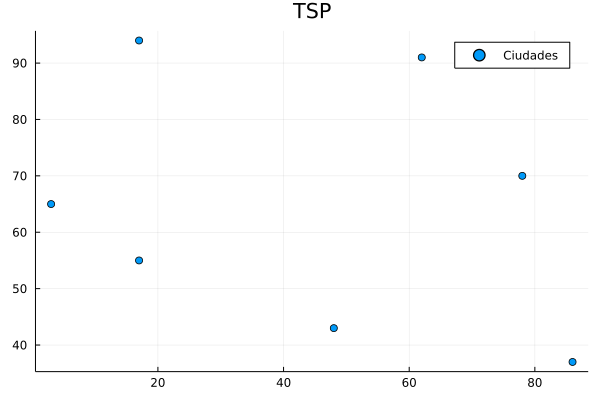

In [16]:
using Plots
x = coordinates[:,1]
y = coordinates[:,2]
scatter(x,y, label="Ciudades", title="TSP")

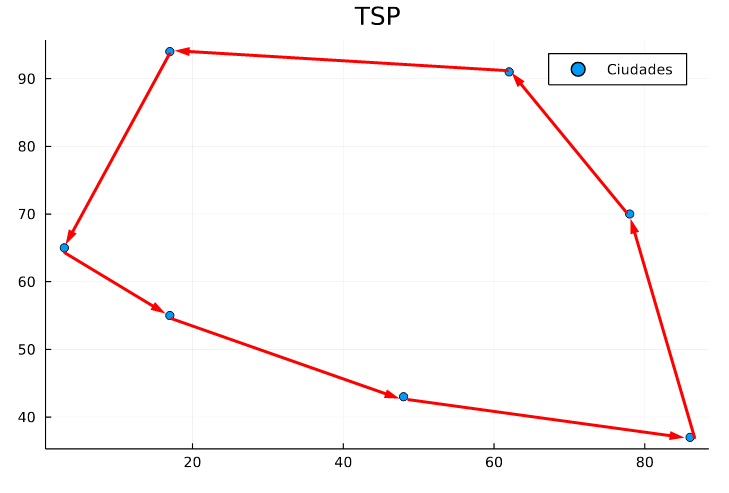